Clicca runtime->esegui tutte

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import joblib 

In [3]:
def to_float(a):
    return np.array(a[1:-1].split(',')).astype(float)



In [4]:
# %cd "gdrive/My Drive/thesis/Colab Notebooks"

In [5]:
!pip install import-ipynb
# !pip install shapely

In [6]:
import import_ipynb 
# import importnb
from pattern1 import Pattern1
from pattern2 import Pattern2
from pattern3 import Pattern3
from pattern4 import Pattern4
from pattern5 import Pattern5
from pattern6 import Pattern6
from pattern7 import Pattern7
from pattern8 import Pattern8
from pattern9 import Pattern9
from pattern10 import Pattern10
from pattern11 import Pattern11
from pattern12 import Pattern12
from pattern13 import Pattern13
from pattern14 import Pattern14
from pattern15 import Pattern15
from pattern16 import Pattern16
from pattern17 import Pattern17
from pattern18 import Pattern18

importing Jupyter notebook from pattern1.ipynb
importing Jupyter notebook from pattern2.ipynb
importing Jupyter notebook from pattern3.ipynb
importing Jupyter notebook from pattern4.ipynb
importing Jupyter notebook from pattern5.ipynb
importing Jupyter notebook from pattern6.ipynb
importing Jupyter notebook from pattern7.ipynb
importing Jupyter notebook from pattern8.ipynb
importing Jupyter notebook from pattern9.ipynb
importing Jupyter notebook from pattern10.ipynb
importing Jupyter notebook from pattern11.ipynb
importing Jupyter notebook from pattern12.ipynb
importing Jupyter notebook from pattern13.ipynb
importing Jupyter notebook from pattern14.ipynb
importing Jupyter notebook from pattern15.ipynb
importing Jupyter notebook from pattern16.ipynb
importing Jupyter notebook from pattern17.ipynb
importing Jupyter notebook from pattern18.ipynb


In [7]:
from shapely.geometry import Polygon, Point, LineString
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from skimage.morphology import skeletonize
import cv2
from matplotlib import pyplot as plt

# transform the black zones resulted from the homography transformation in the color of the paper
def unique_color(img):
    # plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    # plt.show()

    #create a mask that has False for every pixel that corresponds to black (0) and True for all pixels that are colored
    mask = img > 0
    # print(mask)
    #select only the colored pixels in a new array
    only_color = img[mask]
    # print(only_color)

    #identify all unique colors that were used (unique values of pixels), and for each return their number 
    colors, count = np.unique(only_color, return_counts=True)

    #get the color that had the maximum number of occurences in the image
    max_color = colors[count.argmax()]
    # print(max_color)
    #assign to all the pixels that are false in the mask (meaning the black, 0, pixels) the value of the max_color (which usually is that of the page);
    #in this way we can make the black margins that resulted from the homography become "white"
    img[np.logical_not(mask)] = max_color

    # plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    # plt.show()
    return img

def computeHomographyRhomb(points):
    p_dst = [(382, 219), (852, 219), (852, 537), (382, 537)]
    #add 1 to the tuple of the point with index 2, which is representing the point that has to be adiacent to the rhomb
    point_rhomb = points[2] + (1,)
    #make a mask for all points and set them all on true (1) except for the rhomb point, which gets false(0)
    mask = np.ones(5, dtype=int)
    mask[2] = 0
    #select all the points with the exception of the point with the rhomb, excluded by the mask
    right_points = np.array(points)[np.ma.make_mask(mask)]
    #find the homography transformation matrix between the 4 points of the rectangle of the patient image, and the corresponding points on the example tamplate that we are using; the points are hardcodded in p_dst
    hm, status = cv2.findHomography(np.array(right_points), np.array(p_dst))
    #generate the new point corresponding to the rhomb positioning using the homography matrix
    new_point = np.dot(hm, point_rhomb)
    #transform the point in order to have the third coordinate = 1 => you split by it
    new_point = tuple(np.round(new_point / new_point[2]).astype(int))
    # select the elements between 0 (the first) and 2 (the last) BUT not including the last
    center = new_point[0:2]
    return center


def find_line(img_path):

    # identify the 5 points of interest the homogram 
    points = np.array(file_homog.loc[img_path[:-4]].to_numpy()[0])
    if points.shape == (1,):
        points = np.array(points[0])
    #transform points from a matrix into an array of tuples
    points = [tuple(x) for x in points]

    #compute the homography for the point corresponding to the rhomb
    r_points = computeHomographyRhomb(points)

    # transform the black zones resulted from the homography transformation in the color of the paper
    img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
    #img = cv2.blur(img, (3, 3))

    #initialize the drawing as an array of 0s, in the shape of the image + 3 
    drawing = np.zeros((img.shape[0], img.shape[1], 3))
    #initialize the score result with 0s
    results = np.zeros(18)

    # [STUDIED] Generate score for Pattern 2 (mostly computer vision, + SVM prediction)
    pat2 = Pattern2(img, drawing, joblib.load('../rectangle_model.joblib'), joblib.load('../rectangle_scaler.joblib'))
    # get the drawing that contains the idenitfied lines and the polygon, with the circles drawn in its corners
    # get the resulted score
    # return the figure as a tuple: first is the polygon shape, and the second is the corners (vertices)
    drawing, results[1], ret_fig = pat2.get_score()
    # print(ret_fig)

    #Generate score for Pattern 1 [ANALYTICAL] [COMPUTER VISION]
    # img - initial image; drawing - generated drawing after the initia image
    pat1 = Pattern1(img, drawing)    
    # TODO: explain what is returned
    drawing, results[0], diag1, diag2 = pat1.get_score(ret_fig)
    
    pat6 = Pattern6(img, drawing)
    drawing, results[5], oriz_coord = pat6.get_score(ret_fig, diag1, diag2)    
    pat3 = Pattern3(img, drawing, joblib.load('../rett_diag_model.joblib'), joblib.load('../rett_diag_scaler.joblib'), joblib.load('../rett_diag_score_model.joblib'), joblib.load('../rett_diag_score_scaler.joblib'), img_path)
    drawing, results[2] = pat3.get_score(ret_fig, diag1, diag2, oriz_coord)      
    pat5 = Pattern5(img, drawing, joblib.load('../cross_model.joblib'), joblib.load('../cross_scaler.joblib'), joblib.load('../cross_score_model.joblib'), joblib.load('../cross_score_scaler.joblib'), img_path)
    drawing, results[4] = pat5.get_score()    
    pat4 = Pattern4(img, drawing, diag1, oriz_coord)
    drawing, results[3] = pat4.get_score(diag1, ret_fig) 
    pat7 = Pattern7(img, drawing)
    drawing, results[6], vert = pat7.get_score(ret_fig, diag1, diag2)
    pat8 = Pattern8(img, drawing, diag1, diag2, vert, oriz_coord)
    drawing, results[7] = pat8.get_score() 
    pat9 = Pattern9(img, drawing, vert)
    drawing, results[8] = pat9.get_score(ret_fig, vert)
    pat10 = Pattern10(img, drawing, joblib.load('../face_model.joblib'), joblib.load('../face_scaler.joblib'), joblib.load('../face_score_model.joblib'), joblib.load('../face_score_scaler.joblib'), img_path)
    drawing, results[9] = pat10.get_score(diag2, oriz_coord)
    pat11 = Pattern11(img, drawing, vert, diag2)
    drawing, results[10] = pat11.get_score(ret_fig, diag1, diag2)   
    pat12 = Pattern12(img, drawing, joblib.load('../rail_model.joblib'), joblib.load('../rail_scaler.joblib'), joblib.load('../rail_score_model.joblib'), joblib.load('../rail_score_scaler.joblib'), img_path)
    drawing, results[11] = pat12.get_score()
    pat13 = Pattern13(img, drawing, r_points, ret_fig)
    drawing, results[12] = pat13.get_score()       
    pat14 = Pattern14(img, drawing, r_points)
    drawing, results[13], rhomb_fig = pat14.get_score(r_points, diag1, diag2)
    pat15 = Pattern15(img, drawing, joblib.load('../rect_model.joblib'), joblib.load('../rect_scaler.joblib'), joblib.load('../rect_score_model.joblib'), joblib.load('../rect_score_scaler.joblib'), img_path)
    drawing, results[14] = pat15.get_score(ret_fig)
    pat16 = Pattern16(img, drawing, r_points)
    drawing, results[15] = pat16.get_score(ret_fig, oriz_coord, r_points)
    pat17 = Pattern17(img, drawing, joblib.load('../cross_vert_model.joblib'), joblib.load('../cross_vert_scaler.joblib'), joblib.load('../cross_vert_score_model.joblib'), joblib.load('../cross_vert_score_scaler.joblib'), img_path)
    drawing, results[16] = pat17.get_score()
    pat18 = Pattern18(img, drawing, joblib.load('../triang_model.joblib'), joblib.load('../triang_scaler.joblib'), joblib.load('../triang_score_model.joblib'), joblib.load('../triang_score_scaler.joblib'), img_path)
    drawing, results[17] = pat18.get_score()
    # plt.imshow(drawing)
    # plt.show()    

    # convert image from grayscale to RGB
    overlap = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # extract from a generated image that contains true (1, white) for all the pixels in the drawing that is different than 0 (black), the pixels that follow the mask that is true for any pixel from the drawing that is different than green (which is usually the contour of the drawing)  
    drawing_mask = np.bitwise_and(np.any(drawing != [0, 0, 0], axis=-1), np.any(drawing != [0, 255, 0], axis=-1))
    # on the colored version of the image, put on the pixels saved on the drawing mask the pixels taken from the generated drawing that contains the analysis and patterns detected
    overlap[drawing_mask] = drawing[drawing_mask]
    plt.imshow(overlap)
    plt.show()    
    #return the results list from the analysis of all the patterns
    return results.astype(np.uint8)
    



['PATTERN1' 'PATTERN2' 'PATTERN3' 'PATTERN4' 'PATTERN5' 'PATTERN6'
 'PATTERN7' 'PATTERN8' 'PATTERN9' 'PATTERN10' 'PATTERN11' 'PATTERN12'
 'PATTERN13' 'PATTERN14' 'PATTERN15' 'PATTERN16' 'PATTERN17' 'PATTERN18']
thesis-rey-ost_test_photos_301.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or in

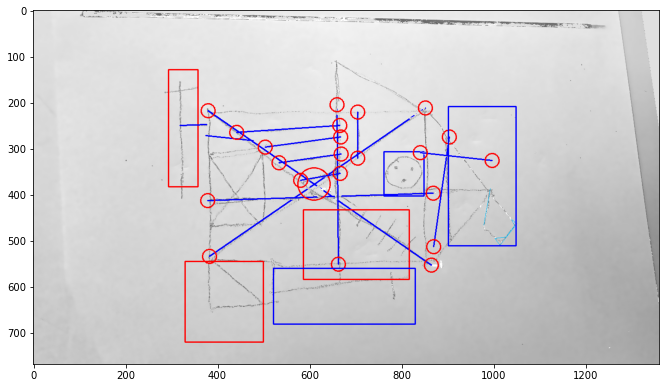

[3 1 1 0 3 3 2 3 0 1 3 1 3 1 3 1 0 1]
thesis-rey-ost_test_photos_302.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN1: diagonali assenti
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Tr

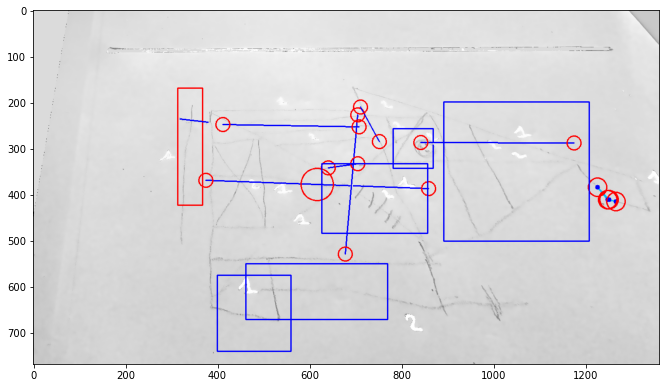

[0 0 0 0 3 3 2 1 0 0 3 0 0 2 1 1 0 0]
thesis-rey-ost_test_photos_303.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator S

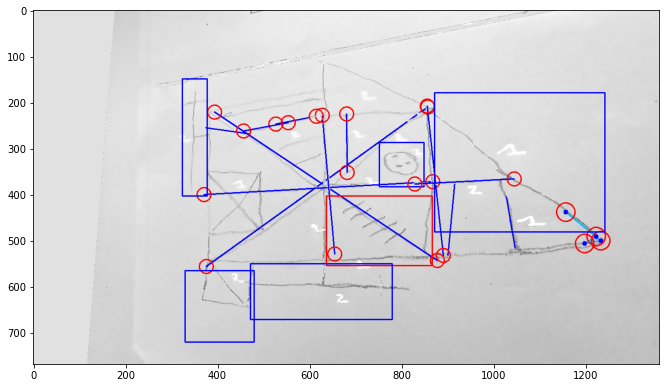

[3 0 0 0 1 3 3 1 0 1 3 3 1 3 1 2 1 1]
thesis-rey-ost_test_photos_304.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator S

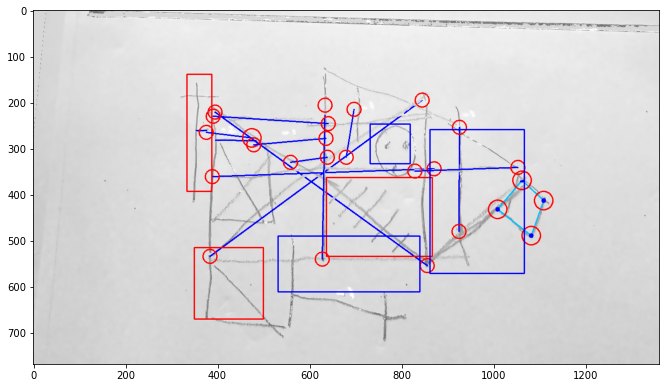

[3 1 0 3 3 3 3 1 0 1 3 3 3 2 3 3 1 1]
thesis-rey-ost_test_photos_305.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN1: diagonale1 non continua
PATTERN1: una diagonale mancante
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packag

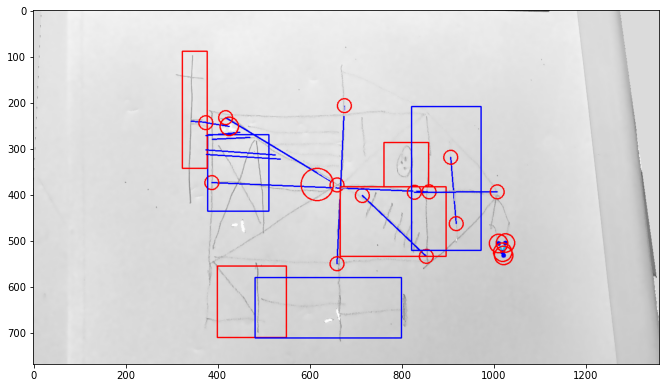

[1 0 3 1 3 3 2 0 0 3 0 1 1 2 3 3 0 0]
thesis-rey-ost_test_photos_306.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN1: angolo basso a dx wrong
PATTERN1: angolo basso a sx wrong
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packa

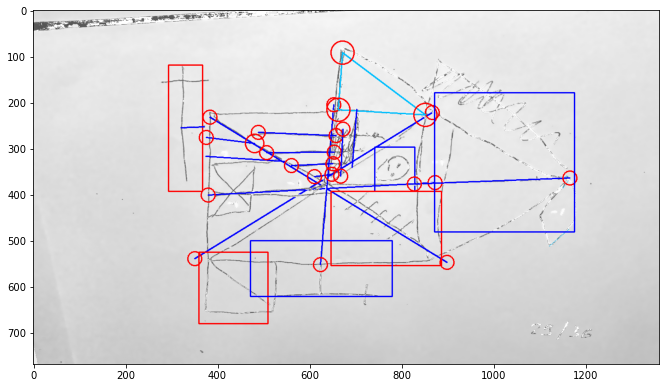

[2 1 1 3 3 3 3 1 3 1 1 1 0 1 3 3 1 1]
thesis-rey-ost_test_photos_307.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator S

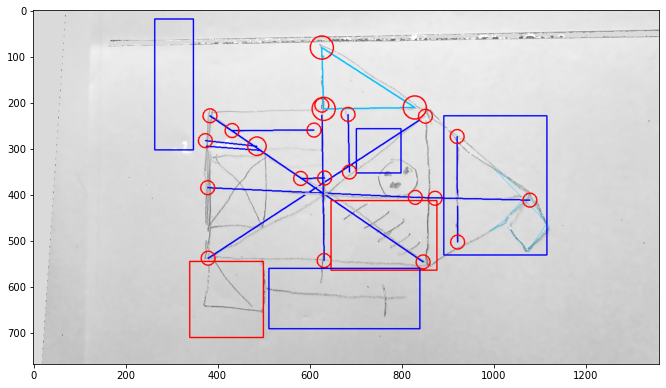

[3 1 1 3 1 3 3 1 3 0 3 3 3 1 3 3 0 1]
thesis-rey-ost_test_photos_308.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN1: una diagonale mancante
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarnin

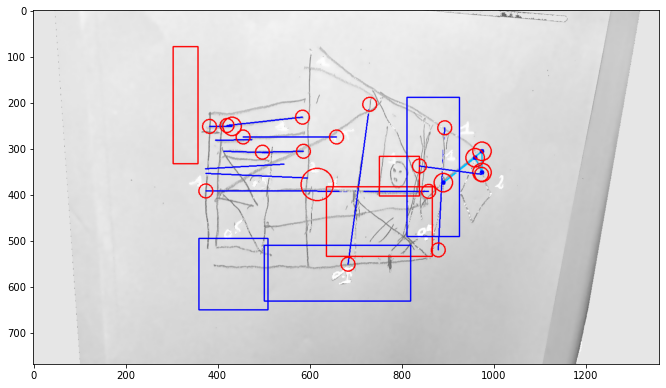

[1 0 1 1 1 3 2 1 0 3 0 1 3 3 1 1 1 1]
thesis-rey-ost_test_photos_310.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN2: the lines are not precise
PATTERN6: vertice sx non tocca rettangolo
PATTERN3: disegno impreciso e diagonali non trovate
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  User

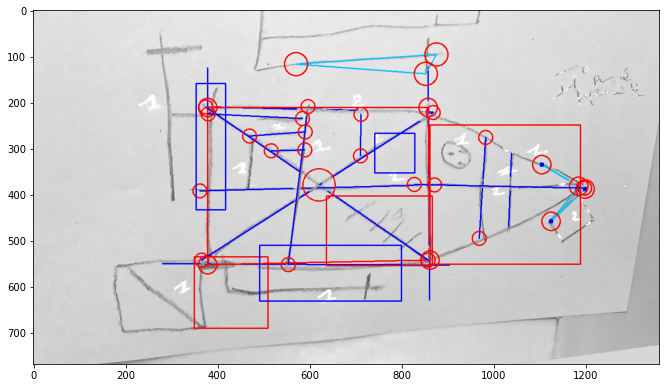

[3 1 0 0 1 3 2 1 1 0 3 3 1 3 3 3 1 3]
thesis-rey-ost_test_photos_311.png
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
PATTERN6: non interseca diagonali
PATTERN3: disegno impreciso
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\aida\anaconda3\envs\rocf2_env\lib\site-packages\sk

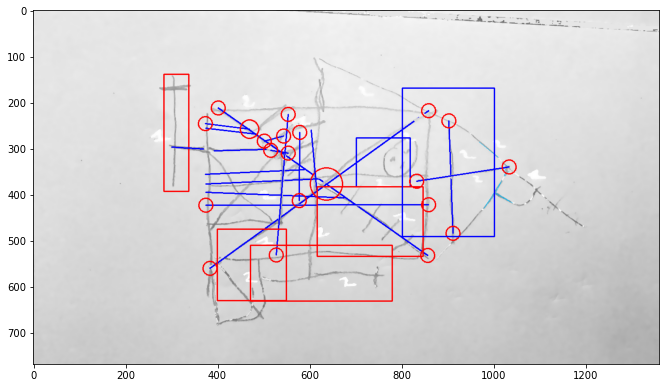

[3 1 1 1 1 2 2 1 0 1 1 3 3 1 3 1 3 1]


In [8]:
import ast
def to_tuple(t):
    return ast.literal_eval(t)

def label_conv(s):
    if s == 'NORMALI':
        return 0
    if s == 'MCI':
        return 1
    if s == 'DEMENZA':
        return 2

root = '../' 
hom_folder = os.path.join(root, 'new_sample')

#read data about tests from Database completo .csv
labels = pd.read_csv('../Database completo .csv', header=0, index_col=0, delimiter=';')

#save the pattern list 
pattern_list = labels.columns.values[3:-1]
print(pattern_list)

#set the size of the plot figure
plt.rcParams['figure.figsize'] = [12, 6.5]

#read the name of the homogram files, with the points that represent the delimitation of the 5 points of interest  
file_homog = pd.read_json(os.path.join(hom_folder, 'points.txt'), lines=True).set_index('name')

#guesses = []
sys_results = []
result_csv = {}
names = []
count = 0

# img_path = os.path.join('', 'NEW_ROCF_RC375.png')

is_header = True
#iterate over image paths in "../new_sample"
for img_path in os.listdir(hom_folder):

    #if the current image path has the .png extension
    if img_path.endswith('.png'):      
        #names.append(name)
        #select the name of the image by removing the last 4 chatacters, so without the extension
        name = img_path[:-4]
        #add the name in the list of names
        names.append(name)
        print(img_path)

        # identify the patterns in the image
        results = find_line(img_path)


        #scores = labels.loc[name][pattern_list].to_numpy()   
        #wrong_guesses = np.logical_not(np.equal(results, scores))
        #print('wrong guesses = {}'.format(pattern_list[wrong_guesses]))
        #print('my result vs. actual results = {}'.format(list(zip(tuple(results[np.nonzero(wrong_guesses)]), tuple(scores[np.nonzero(wrong_guesses)])))))
        #print(labels.loc[name][pattern_list])
        #guesses.append(np.column_stack((results, scores)))  
        
        df = pd.DataFrame([results], columns=pattern_list)

        df["name"] = img_path[:-4]

        if is_header: 
            df.to_csv('../results/total_scores.csv', header = True, index=False)
            is_header = False
        else:
            df.to_csv('../results/total_scores.csv', mode = 'a', header = False, index=False)

        # sys_results.append(results)
        
        print(results)
        # sys_results.append(results)
        '''if not count % 10:
            right_guess = np.array([[guess[0]==guess[1] for guess in guess_t] for guess_t in guesses])
            for template in range(right_guess.shape[1]):
            print('accuracy {}: {}'.format(pattern_list[template], np.sum(right_guess[:, template])*100/right_guess.shape[0]))'''





        

In [9]:
sys_results

[]

Ignora da qui in poi

In [10]:
# new_df = pd.DataFrame(data=sys_results,
#                       index=names,
#                       columns=pattern_list)
# new_df.to_csv('..results/nuovi_result.csv')